# Group project - Computational Game Theory

# Playing soccer game

In this game 2 agents play against each other to score goals with a single ball.
Both players can have their own learning algorithms assigned to make comparing different learners possible.
This is done in an abstract way to make testing alternate situations easy.

## TOC
- Group info
- Important note
- Required imports
- Storing and loading variables
- Code to represent the players and games
   - The WolfSoccerPlayer class
   - The PHCSoccerPlayer class
   - The SoccerGame class
   - The average_games function
- Playing the game (WoLF)
- Playing the game (PHC)
- Plotting averages
- Plotting single run

## Student info
| Name     | Student number                        | Email address                               |
| :---     | :---                          | :---                                |
| Alexis Francois Verdoodt | _ | _ |
| Lennert Bontinck | 568702 | [lennert.bontinck@vub.be](mailto:lennert.bontinck@vub.be) |
| Sofyan Ajridi | _ | _ |
| Wolf De Wulf | 546395 | [wolf.de.wulf@vub.be](mailto:wolf.de.wulf@vub.be) |

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping. The result of some lengthy processes is saved to a Pickle file to make the results available for reuse later.

## Required imports
All imports required for this notebook.

In [6]:
# General imports
import numpy as np
import random
import statistics as stats
import math
from scipy import stats as sstats

# Allow for deep copying instead of python references (default)
import copy

# Plotting imports
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# Library to save vars to files
import pickle

## Storing and loading variables
Improves reproducibility and allows for using previous results of lengthy processes.

In [8]:
def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
    
#-------------------------

#save to file example
#save_var_to_file("folder/name", var_to_save)
    
#open from file example
#get_var_from_file = get_var_from_file("folder/name")

## Code to represent the players and games
Let's start by making a way of representing the games and playing them in an abstract manner.

### The WolfSoccerPlayer class - TODO
A class for defining a soccer player according to the WoLF algorithm.

In [15]:
class WolfSoccerPlayer:
    """
    A class used to represent a soccer player using the WoLF algorithm.
    Keeps track of it's current state and the map available.
    Running into a wall will result in staying in the same location.
    Running into another player will result in staying in the same location.
    Reaching goal wil result in all players returning to their initial state.
    Makes use of a time-varrying alpha and delta thus it's not needed to specify these.

    ...

    Attributes
    ----------
    q_values : list
        List containing the player's current q values estimate for north(0), south(1), east(2), west(3) and stand(4)
       
    states
    
    TODO : TODO
        TODO 
        
    Methods
    -------
    choose_action()
        Chooses an action based on the current policy probabilities estimate for  north(0), south(1), east(2), west(3) and stand(4).
        There's a 0.05 probability of chosing a random action for exploration.
        Returns the chosen action, which is thus represented as an integer.
    
    TODO : TODO
        TODO
    
    Helper Methods
    -------
    player_is_winning()
        Returns a bool specifying if a user is winning or not
    
    TODO : TODO
        TODO
    """
    def __init__(self, initial_q_value, initial_policy_probabilities, gamma, starts_left):
        """
        Parameters
        ----------
        TODO : TODO
            TODO
        """
        self.grid_sizes = [4, 5] # start counting from 0 -> 4x5 grid
        self.amount_of_states = 20 # 4 x 5
        
        x = random.randomtInt(0,1) if starts_left else random.randomtInt(3,4)  # random spot in left part, random spot in right part otherwise
        y = random.randomtInt(0,4)
        
        self.start_state = [random.randomtInt(0,1) , random.randomtInt(0,4)] if starts_left else [random.randomtInt(3,4) , random.randomtInt(0,4)] # random spot in left part, random spot in right part otherwise
        self.current_state = [y , x]
        self.actions = [i for i in range(4)] # N S E W ST for each state and non changing
        self.state_counts = [[0 for _ in range(4)] for _ in range (4)]

        self.q_values = [[[initial_q_value]*4 for _ in range(3)] for _ in range (3)] # N S E W ST q-val for each state of 3 x 3 grid
        self.policy_probabilities = [[[initial_policy_probabilities]*4 for _ in range(3)] for _ in range (3)] # N S E W ST for each state of 3 x 3 grid
        self.average_policy_probabilities = [[[initial_policy_probabilities]*4 for _ in range(3)] for _ in range (3)] # N S E W for each state of 3 x 3 grid
        self.gamma = gamma
        
        
        
        
    
    def choose_action(self):       
        # give room for some exploration (e.g. stuck in an extreme)
        if  random.random() < 0.05:
            return random.choice(self.actions)
        
        # generate cumulative probabilities
        cum_probs = np.cumsum(self.policy_probabilities_for_current_state())
        
        # chose an action for the cumulative probs
        rnd = random.random()
        for idx in range(len(cum_probs)):
            if (rnd < cum_probs[idx]):
                return [idx, self.get_new_state_for_move(idx)]
        
     
    def increment_state_count(self):
        state = self.current_state
        self.state_counts[state[0]][state[1]] += 1
        
    
    def update_q_value_for_action(self, action, received_reward):
        crt_alpha = self.timed_alpha()
        state = self.current_state
        new_state = get_new_state_for_move(action)
        self.q_values[state[0]][state[1]][action] = ((1-crt_alpha) * self.q_values[state[0]][state[1]][action]) + crt_alpha * (received_reward + self.gamma * np.max(self.q_values[new_state[0]][new_state[1]]))
                
    
    def update_average_policy_probabilities(self):
        state = self.current_state
        c = self.state_counts[state[0]][state[1]]
    
        for action in self.actions:
            polprob = self.policy_probabilities_for_current_state[action]
            avgpolprob = self.average_policy_probabilities_for_current_state[action]
            
            state = self.current_state
            self.average_policy_probabilities[state[0]][state[1]][action] += (1/c)*(polprob-avgpolprob)
    
  
    def update_policy_probabilities(self):
        #determine delta
        delta = self.timed_winning_delta() if self.player_is_winning() else self.timed_losing_delta()
        
        #determine 1 max q-value
        state = self.current_state
        max_action = np.argmax(self.q_values[state[0]][state[1]])
        
        for action in self.actions:
            if action == max_action:
                self.policy_probabilities[state[0]][state[1]][action] = min(1.0,  self.policy_probabilities[state[0]][state[1]][action] + delta)
            else: #devide losing over 2 from the 3 actions
                self.policy_probabilities[state[0]][state[1]][action] = max(0.0,  self.policy_probabilities[state[0]][state[1]][action] - (delta/3))

        
       
    def player_is_winning(self):
        policy_sum = 0
        avg_policy_sum = 0
        state = self.current_state
        for action in self.actions:
            policy_sum += self.policy_probabilities[state[0]][state[1]][action] * self.q_values[state[0]][state[1]][action]
            avg_policy_sum += self.average_policy_probabilities[state[0]][state[1]][action] * self.q_values[state[0]][state[1]][action]
            
        return policy_sum > avg_policy_sum
    
    
    def timed_alpha(self):
        state = self.current_state
        return 1 / (10 + (self.state_counts[state[0]][state[1]]/500))
    
    
    def timed_winning_delta(self): 
        state = self.current_state
        return 1 / (1000 + (self.state_counts[state[0]][state[1]]/10))
    
    
    def timed_losing_delta(self): 
        state = self.current_state
        return 4 / (1000 + (self.state_counts[state[0]][state[1]]/10))
    
    
    def policy_probabilities_for_current_state(self): 
        state = self.current_state
        return self.policy_probabilities[state[0]][state[1]]
    
    
    def average_policy_probabilities_for_current_state(self): 
        state = self.current_state
        return self.average_policy_probabilities[state[0]][state[1]]
    
    
    def get_new_state_for_move(self, move): 
        crt_state = self.current_state
        if (crt_state == start_state and move == 0 ):
            rnd = random.random()
            if rnd > 0.5:
                return [crt_state[0], crt_state[1] + 1] #move up
            else:
                return crt_state #failed
        elif (move == 0): # N
            new_height = min(crt_state[0] + 1, self.grid_sizes[0])
            return [crt_state[0], new_height]
        elif (move == 0): # S
            new_height = max(crt_state[0] - 1, 0)
            return [crt_state[0], new_height]
        elif (move == 0): # E
            new_width = min(crt_state[1] + 1, self.grid_sizes[1])
            return [new_width, crt_state[1]]
        else: # W
            new_height = max(crt_state[1] - 1, 0)
            return [new_width, crt_state[1]]
            

### The PHCSoccerPlayer class - TODO
A class for defining a RPC player according to the PHC algorithm.
Some of the WoLF specific functions will just be dummy functions

### The PHCGame class - TODO
This game does't require the notion of states since the results are indepent of a given state. Thus the transition function can simply return the initial start state for every iteration.

In [31]:
class RPCGame:
    """
    A class used to represent a RPC game.
    Has no notion of state since there is only 1 state.

    ...

    Attributes
    ----------
    TODO
    
    Methods
    -------
    TODO
    """
    def __init__(self, players, goal_state):
        """
        Parameters
        ----------
        players : list
            List containing all (2) players for the game.
        """
        self.players = players
        self.goal_state = goal_state
        
        
        
        
        
    def play_game(self, iterations):
        results = [[0, 0] for _ in range(iterations)] #move player1 and player2 from initial square
        
        
        for iteration in range(iterations):
            # dit nog volledig todo; actie return en geeft goal state volgens agent (dus al muur check etc)
            # nog kijken of ze niet naar zelfde moven, of een agent naar een goal moved en afhankelijk daarvan
            # de juiste reward en nieuwe state meegeven, mss bool maken "moveworks" ofso om te zeggen of update ook
            # echt doen of niet door collision en ook een var returntostart mss als een vd 2 agents klaar is?
            # dan saven enkel als de move plaats vond uit de start state anders een "nope" dat je kan wegfilteren later
            # determine player moves TODO
            player1_move, player1_goal_state = self.players[0].choose_action()
            player2_move, player2_goal_state = self.players[1].choose_action()
            
            # add to state count TODO
            self.players[0].increment_state_count()
            self.players[1].increment_state_count()
            
            # calculate corresponding reward and update q-value TODO
            reward = self.payoff_matrix[player1_move][player2_move]
            self.players[0].update_q_value_for_action(player1_move, reward)
            self.players[1].update_q_value_for_action(player2_move, -reward)
            
            # update estimate of average policy TODO
            self.players[0].update_average_policy_probabilities(fixed_first_move_player_1)
            self.players[1].update_average_policy_probabilities(fixed_first_move_player_2)
            
            # update policy TODO
            self.players[0].update_policy_probabilities(fixed_first_move_player_1)
            self.players[1].update_policy_probabilities(fixed_first_move_player_2)
            
            # save result: rock, paper TODO
            results[iteration][0] = copy.deepcopy(self.players[0].policy_probabilities[0])
            results[iteration][1] = copy.deepcopy(self.players[0].policy_probabilities[1])
                
        return results

### The average_games function - TODO

In [32]:
def average_games(game, iterations, trials):
    results = [[0]*iterations for _ in range(trials)] 
    for trial in range(trials):
        copied_game = copy.deepcopy(game)
        results[trial] = copied_game.play_game(iterations)
    return results
        

## Playing the game (WoLF) - TODO

In [52]:
initial_q_value = 0
initial_policy_probabilities = 1/3
gamma = 0.8
iterations = 50000
averaging_amount = 30

player1 = WolfRPCPlayer(initial_q_value, initial_policy_probabilities, gamma)
player2 = WolfRPCPlayer(initial_q_value, initial_policy_probabilities, gamma)
players = [player1, player2]

game = RPCGame(players)

results = average_games(game, iterations, averaging_amount)
save_var_to_file("RPC/wolf_result", results)

## Playing the game (PHC | time-varying) - TODO

## Plotting averages - TODO

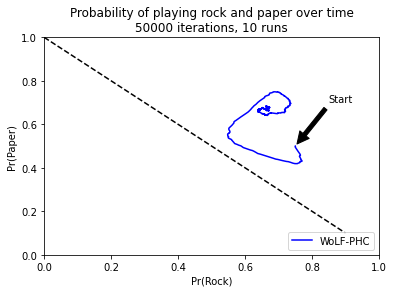

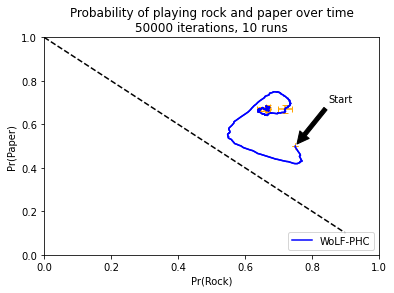

In [110]:
# get the results
results = [["WoLF-PHC", get_var_from_file("RPC/wolf_result")]]
           #["PHC with decay", get_var_from_file("RPC/phc_result_time_varying")]]

colors = ["blue",
         "orange"]

error_colors = ["orange",
                "blue"]


# --------------------------------------------------------------------------
color_idx = 0
for result in results:
    result_data = result[1]
    
    if result[0] == "WoLF-PHC": # transform to upperright
        result_data_rock = [[1 - data[0] for data in single_result] for single_result in result_data]
        result_data_paper = [[1 - data[1] for data in single_result] for single_result in result_data]
    else:
        result_data_rock = [[data[0] for data in single_result] for single_result in result_data]
        result_data_paper = [[data[1] for data in single_result] for single_result in result_data]
    
    average_result_rock = [np.mean(x) for x in zip(*result_data_rock)]
    average_result_paper = [np.mean(x) for x in zip(*result_data_paper)]
    
    #determine iterations and averaging amount (trials)
    iterations = len(average_result_rock)
    averaging_amount = len(result_data)
    
    # plot
    x = average_result_rock
    y = average_result_paper
    plt.plot(x, y,
             "-",
             label=result[0],
             color=colors[color_idx])
    
    color_idx += 1
    
    #show start
    if result[0] == "WoLF-PHC": # transform to upperright
        plt.annotate('Start', xy=(x[0],y[0]), xytext=(x[0]+0.1,y[0]+0.2), arrowprops=dict(facecolor='black', shrink=0.05))
    else:
        plt.annotate('Start', xy=(x[0],y[0]), xytext=(x[0]-0.2,y[0]-0.2), arrowprops=dict(facecolor='black', shrink=0.05))

# show diagonal
plt.plot(np.arange(0, 1, 1/10), np.arange(1, 0, -1/10), "--", color="black")
        
plt.legend(loc="lower right")

plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel('Pr(Rock)')
plt.ylabel('Pr(Paper)')
plt.title('Probability of playing rock and paper over time\n' + str(iterations) + " iterations, " + str(averaging_amount) + " runs")

plt.savefig("graphs/RPC/rpc.png", dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------------------------------
color_idx = 0
for result in results:
    # average results over trials
    result_data = result[1]
    
    if result[0] == "WoLF-PHC": # transform to upperright
        result_data_rock = [[1 - data[0] for data in single_result] for single_result in result_data]
        result_data_paper = [[1 - data[1] for data in single_result] for single_result in result_data]
    else:
        result_data_rock = [[data[0] for data in single_result] for single_result in result_data]
        result_data_paper = [[data[1] for data in single_result] for single_result in result_data]
    result_data_rock = [np.array(x) for x in result_data_rock]
    result_data_paper = [np.array(x) for x in result_data_paper]
    
    average_result_rock = [np.mean(x) for x in zip(*result_data_rock)]
    average_result_paper = [np.mean(x) for x in zip(*result_data_paper)]
    
    #determine iterations and averaging amount (trials)
    iterations = len(average_result_rock)
    averaging_amount = len(result_data)
    
    # plot
    x = average_result_rock
    y = average_result_paper
    plt.plot(x, y,
             "-",
             label=result[0],
             color=colors[color_idx])
           
    xerror = [sstats.sem(k) for k in zip(*result_data_rock)]
    yerror = [sstats.sem(k) for k in zip(*result_data_paper)]
    plt.errorbar(x, y, yerr=yerror, xerr=xerror, errorevery=5000, color=colors[color_idx], alpha=1, ecolor=error_colors[color_idx], capsize=3, )
    
    color_idx += 1
    
    #show start
    if result[0] == "WoLF-PHC": # transform to upperright
        plt.annotate('Start', xy=(x[0],y[0]), xytext=(x[0]+0.1,y[0]+0.2), arrowprops=dict(facecolor='black', shrink=0.05))
    else:
        plt.annotate('Start', xy=(x[0],y[0]), xytext=(x[0]-0.2,y[0]-0.2), arrowprops=dict(facecolor='black', shrink=0.05))

# show diagonal
plt.plot(np.arange(0, 1, 1/10), np.arange(1, 0, -1/10), "--", color="black")
        
plt.legend(loc="lower right")

plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel('Pr(Rock)')
plt.ylabel('Pr(Paper)')
plt.title('Probability of playing rock and paper over time\n' + str(iterations) + " iterations, " + str(averaging_amount) + " runs")

plt.savefig("graphs/RPC/rpc_w_error.png", dpi=300, bbox_inches='tight')
plt.show()

## Plotting single run - TODO

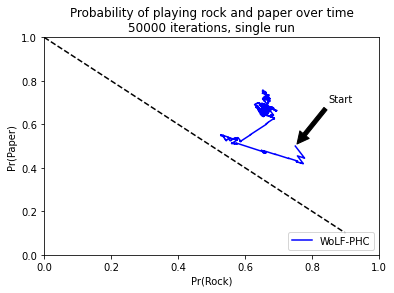

In [109]:
# get the results
results = [["WoLF-PHC", get_var_from_file("RPC/wolf_result")]]
           #["PHC with decay", get_var_from_file("RPC/phc_result_time_varying")]]

colors = ["blue",
         "orange"]


# --------------------------------------------------------------------------
color_idx = 0
for result in results:
    # average results over trials
    result_data = result[1][0]
    if result[0] == "WoLF-PHC": # transform to upperright
        result_data_rock = [1 - data[0] for data in result_data]
        result_data_paper = [1 - data[1] for data in result_data]
    else:
        result_data_rock = [data[0] for data in result_data]
        result_data_paper = [data[1] for data in result_data]
    
    
        
    
    #determine iterations
    iterations = len(result_data)
    
    # plot
    #x = np.arange(0, iterations, 1)
    #y = result_data_rock
    x = result_data_rock
    y = result_data_paper
    plt.plot(x, y,
             "-",
             label=result[0],
             color=colors[color_idx])
    
    color_idx += 1
    
    #show start
    if result[0] == "WoLF-PHC": # transform to upperright
        plt.annotate('Start', xy=(x[0],y[0]), xytext=(x[0]+0.1,y[0]+0.2), arrowprops=dict(facecolor='black', shrink=0.05))
    else:
        plt.annotate('Start', xy=(x[0],y[0]), xytext=(x[0]-0.2,y[0]-0.2), arrowprops=dict(facecolor='black', shrink=0.05))
    

# show diagonal
plt.plot(np.arange(0, 1, 1/10), np.arange(1, 0, -1/10), "--", color="black")

plt.legend(loc="lower right")

plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel('Pr(Rock)')
plt.ylabel('Pr(Paper)')
plt.title('Probability of playing rock and paper over time\n' + str(iterations) + " iterations, single run")

plt.savefig("graphs/RPC/rpc_single.png", dpi=300, bbox_inches='tight')
plt.show()